In [4]:
!rm -rf cvae-quadratreeMRF # Remove old version if exists
!git clone https://github.com/realjules/cvae-quadratreeMRF.git
import sys
sys.path.append('/kaggle/working/cvae-quadratreeMRF')

Cloning into 'cvae-quadratreeMRF'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 40 (delta 7), reused 33 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 1.59 MiB | 33.29 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [5]:
# Import required libraries
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.morphology import disk  # Import disk directly from skimage.morphology
from glob import glob
import random
import os
from tqdm.notebook import tqdm
import cv2

# Import project modules
from dataset.dataset import ISPRS_dataset
from net.net import CRFNet
from net.loss import CrossEntropy2d
from utils.utils_dataset import convert_to_color, convert_from_color
from utils.utils_network import compute_class_weight
from utils.utils import accuracy

In [6]:
# Configuration Cell - Edit parameters here
# ---------------------------------------------------

# Dataset parameters
DATASET = 'Vaihingen'
FOLDER = "../input/potsdamvaihingen/"  # Path to dataset
MAIN_FOLDER = FOLDER + 'ISPRS_semantic_labeling_Vaihingen/'
DATA_FOLDER = MAIN_FOLDER + 'top/top_mosaic_09cm_area{}.tif'
LABEL_FOLDER = MAIN_FOLDER + 'gts_for_participants/top_mosaic_09cm_area{}.tif'

# Data split
train_ids = ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
test_ids = ['5', '21', '15', '30']

# Input and preprocessing parameters
WINDOW_SIZE = (256, 256)  # Patch size
STRIDE = 32  # Stride for testing
IN_CHANNELS = 3  # Number of input channels (e.g. RGB)
CACHE = True  # Store the dataset in-memory
ERO_DISK_SIZE = 3  # Size of the morphological disk for erosion

# Class definitions
LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"]  # Label names
N_CLASSES = len(LABELS)  # Number of classes

# Training parameters
BATCH_SIZE = 10  # Number of samples in a mini-batch
EPOCHS = 30  # Number of training epochs
SAVE_EPOCH = 10  # Save model every N epochs
OUTPUT_FOLDER = "./output"  # Output directory

# Optimization parameters
base_lr = 0.01  # Base learning rate
MOMENTUM = 0.9  # Momentum for SGD optimizer
WEIGHT_DECAY = 0.0005  # Weight decay for regularization
LR_STEPS = [25, 35, 45]  # Steps for learning rate decay
LR_GAMMA = 0.1  # Gamma factor for learning rate decay

# Model parameters
BILINEAR = True  # Whether to use bilinear upsampling in the model

# Visualization parameters
DISPLAY_ITER = 100  # Display progress every N iterations

# Create output directory if it doesn't exist
import os
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Initialize weights for class balancing
WEIGHTS = torch.ones(N_CLASSES)  # Weights for class balancing

print("Configuration loaded!")

Configuration loaded!


In [7]:
print("Tiles for training:", train_ids)
print("Tiles for testing:", test_ids)

# Initialize training and test datasets
train_set = ISPRS_dataset(
    ids=train_ids,
    ids_type='TRAIN',
    gt_type='full',  # Options: 'full', 'conncomp', 'ero'
    gt_modification=disk(ERO_DISK_SIZE),  # Erosion disk
    data_files=DATA_FOLDER,
    label_files=LABEL_FOLDER,
    window_size=WINDOW_SIZE,
    cache=CACHE,
    augmentation=True  # Enable data augmentation for training
)

test_set = ISPRS_dataset(
    ids=test_ids,
    ids_type='TEST',
    gt_type='full',
    gt_modification=disk(ERO_DISK_SIZE),
    data_files=DATA_FOLDER,
    label_files=LABEL_FOLDER,
    window_size=WINDOW_SIZE,
    cache=CACHE,
    augmentation=False  # No augmentation for testing
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

# Initialize the model
net = CRFNet(n_channels=IN_CHANNELS, n_classes=N_CLASSES, bilinear=BILINEAR)

# Move model to GPU if available
if torch.cuda.is_available():
    net.cuda()
    WEIGHTS = WEIGHTS.cuda()

# Set up optimizer with different learning rates for encoder and decoder
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params': [value], 'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2
        params += [{'params': [value], 'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, LR_STEPS, gamma=LR_GAMMA)

print("Setup complete! Ready to train.")

Tiles for training: ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
Tiles for testing: ['5', '21', '15', '30']
Setup complete! Ready to train.


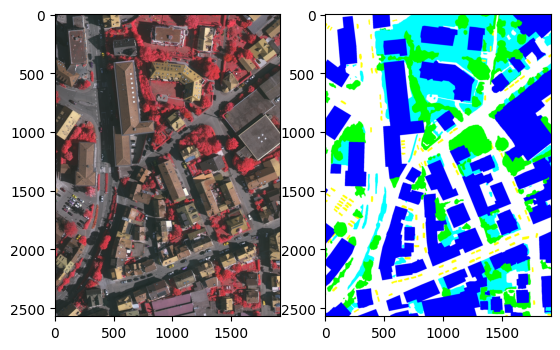

In [8]:
# # Parameters
# WINDOW_SIZE = (256, 256) # Patch size
# STRIDE = 32 # Stride for testing
# IN_CHANNELS = 3 # Number of input channels (e.g. RGB)
# FOLDER = "../input/potsdamvaihingen/" # Replace with your "/path/to/the/ISPRS/dataset/folder/"
# BATCH_SIZE = 10 # Number of samples in a mini-batch

# LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
# N_CLASSES = len(LABELS) # Number of classes
# WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
# CACHE = True # Store the dataset in-memory

# DATASET = 'Vaihingen'
# MAIN_FOLDER = FOLDER + 'ISPRS_semantic_labeling_Vaihingen/'
# DATA_FOLDER = MAIN_FOLDER + 'top/top_mosaic_09cm_area{}.tif'
# LABEL_FOLDER = MAIN_FOLDER + 'gts_for_participants/top_mosaic_09cm_area{}.tif'

# # ISPRS color palette
# # Let's define the standard ISPRS color palette
# palette = {0 : (255, 255, 255), # Impervious surfaces (white)
#            1 : (0, 0, 255),     # Buildings (blue)
#            2 : (0, 255, 255),   # Low vegetation (cyan)
#            3 : (0, 255, 0),     # Trees (green)
#            4 : (255, 255, 0),   # Cars (yellow)
#            5 : (255, 0, 0),     # Clutter (red)
#            6 : (0, 0, 0)}       # Undefined (black)

# invert_palette = {v: k for k, v in palette.items()}

# We load one tile from the dataset and we display it
img = io.imread('../input/potsdamvaihingen/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area1.tif')
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img)

# We load the ground truth
gt = io.imread('../input/potsdamvaihingen/ISPRS_semantic_labeling_Vaihingen/gts_for_participants/top_mosaic_09cm_area1.tif')
fig.add_subplot(122)
plt.imshow(gt)
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Train (epoch 1/30) [0/1000 (0%)]	Loss: 0.984841
Train (epoch 1/30) [100/1000 (10%)]	Loss: 0.882385
Train (epoch 1/30) [200/1000 (20%)]	Loss: 0.954223
Train (epoch 1/30) [300/1000 (30%)]	Loss: 1.035799
Train (epoch 1/30) [400/1000 (40%)]	Loss: 0.822709
Train (epoch 1/30) [500/1000 (50%)]	Loss: 1.496218
Train (epoch 1/30) [600/1000 (60%)]	Loss: 0.949533
Train (epoch 1/30) [700/1000 (70%)]	Loss: 0.769714
Train (epoch 1/30) [800/1000 (80%)]	Loss: 0.945509
Train (epoch 1/30) [900/1000 (90%)]	Loss: 0.807250
Epoch 1/30 completed. Average Loss: 1.074936 Accuracy: 93.65%


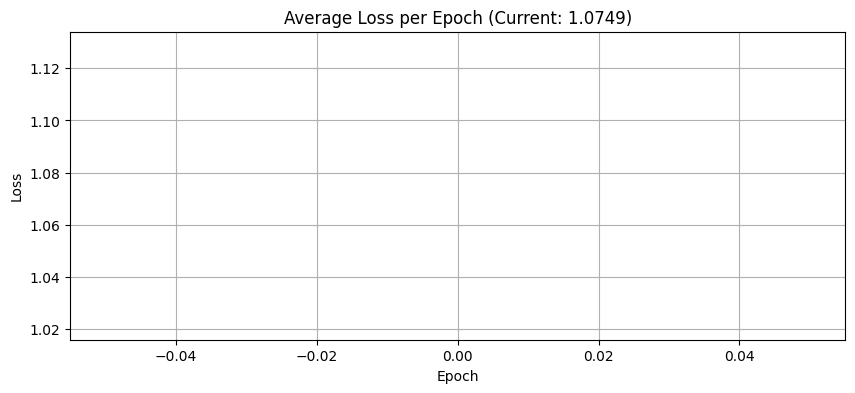

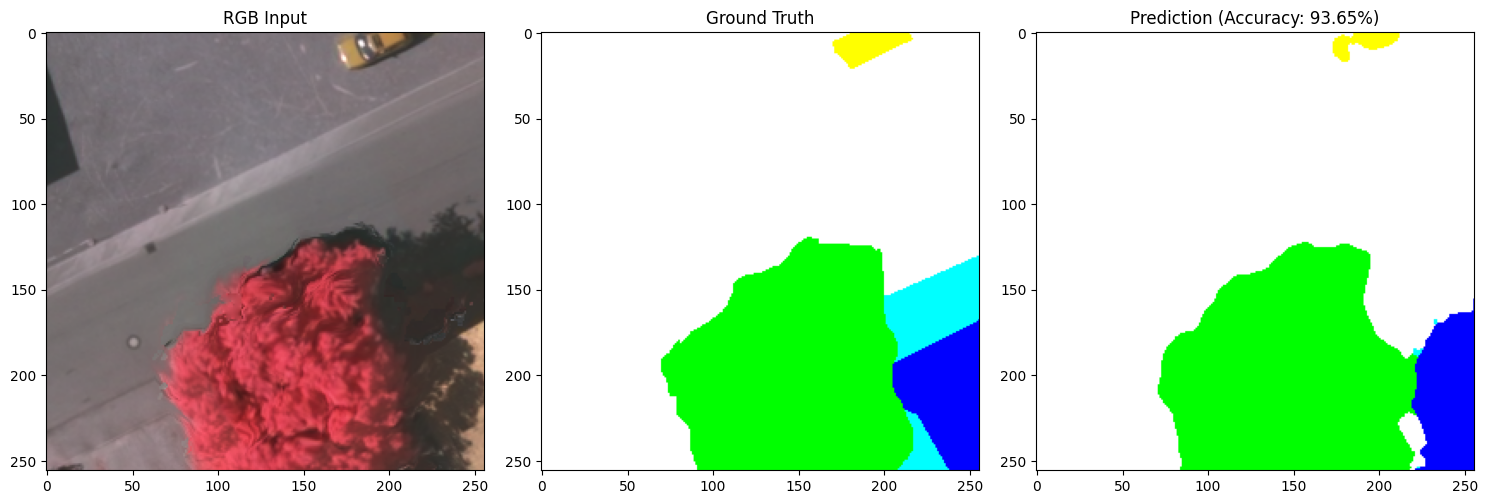

Train (epoch 2/30) [0/1000 (0%)]	Loss: 0.833377
Train (epoch 2/30) [100/1000 (10%)]	Loss: 1.090902
Train (epoch 2/30) [200/1000 (20%)]	Loss: 0.945947
Train (epoch 2/30) [300/1000 (30%)]	Loss: 0.804552


In [ ]:
# Training Function Cell - Execute this cell to start training
# ---------------------------------------------------

# Training function
def train_model():
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    all_epoch_losses = []  # Track average loss per epoch

    iter_ = 0

    for e in tqdm(range(1, EPOCHS + 1)):
        net.train()
        epoch_losses = []  # Track losses for this epoch
        last_batch_data = None  # Store the last batch data for visualization
        
        for batch_idx, (data, target) in enumerate(train_loader):
            # Process target for multi-scale supervision
            target = target.data.cpu().numpy()
            target = np.transpose(target, [1, 2, 0])
            target3 = np.transpose(cv2.resize(target, dsize=(128, 128), interpolation=cv2.INTER_NEAREST), [2, 0, 1])
            target2 = np.transpose(cv2.resize(target, dsize=(64, 64), interpolation=cv2.INTER_NEAREST), [2, 0, 1])
            target1 = np.transpose(cv2.resize(target, dsize=(32, 32), interpolation=cv2.INTER_NEAREST), [2, 0, 1])
            target = np.transpose(target, [2, 0, 1])

            # Move data to GPU
            data, target = data.cuda(), torch.from_numpy(target).cuda()

            # Save the last batch for visualization
            if batch_idx == len(train_loader) - 1:
                last_batch_data = (data, target)

            optimizer.zero_grad()

            # Forward pass
            output, out_fc, out_neigh, _ = net(data)

            # Calculate losses at different scales
            loss = CrossEntropy2d(output, target, weight=WEIGHTS)
            loss_fc1 = CrossEntropy2d(
                out_fc[0],
                torch.from_numpy(target1).type(torch.LongTensor).cuda(),
                weight=compute_class_weight(target1).cuda()
            )
            loss_fc2 = CrossEntropy2d(
                out_fc[1],
                torch.from_numpy(target2).type(torch.LongTensor).cuda(),
                weight=compute_class_weight(target2).cuda()
            )
            loss_fc3 = CrossEntropy2d(
                out_fc[2],
                torch.from_numpy(target3).type(torch.LongTensor).cuda(),
                weight=compute_class_weight(target3).cuda()
            )

            # Pairwise loss for neighborhood consistency
            pairwise_loss = CrossEntropy2d(out_neigh, target, weight=WEIGHTS)

            # Combine all losses
            total_loss = (loss + loss_fc1 + loss_fc2 + loss_fc3) / 4 + pairwise_loss

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()

            # Record loss
            loss_value = total_loss.item()
            epoch_losses.append(loss_value)
            losses[iter_] = loss_value
            mean_losses[iter_] = np.mean(losses[max(0, iter_-100):iter_])
            
            # Print occasional progress without images
            if iter_ % DISPLAY_ITER == 0:
                print(f'Train (epoch {e}/{EPOCHS}) [{batch_idx}/{len(train_loader)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss_value:.6f}')
            
            iter_ += 1
        
        # End of epoch - calculate average loss
        avg_epoch_loss = np.mean(epoch_losses)
        all_epoch_losses.append(avg_epoch_loss)
        
        # Visualize results at the end of each epoch
        if last_batch_data is not None:
            with torch.no_grad():
                net.eval()  # Switch to evaluation mode
                data, target = last_batch_data
                
                # Forward pass in eval mode
                output, _, _, _ = net(data)
                
                # Convert data back to CPU for visualization
                rgb = np.asarray(255 * np.transpose(data.cpu().numpy()[0], (1, 2, 0)), dtype='uint8')
                pred = np.argmax(output.detach().cpu().numpy()[0], axis=0)
                gt = target.cpu().numpy()[0]

                # Calculate accuracy
                acc_value = accuracy(pred, gt)
                if np.isnan(acc_value):
                    acc_value = 0.0

                # Print epoch summary
                print(f'Epoch {e}/{EPOCHS} completed. Average Loss: {avg_epoch_loss:.6f} Accuracy: {acc_value:.2f}%')

                # Plot loss curve for all epochs so far
                plt.figure(figsize=(10, 4))
                plt.plot(all_epoch_losses)
                plt.title(f'Average Loss per Epoch (Current: {avg_epoch_loss:.4f})')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.grid(True)
                plt.show()

                # Visualize results
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
                ax1.imshow(rgb)
                ax1.set_title('RGB Input')
                ax2.imshow(convert_to_color(gt))
                ax2.set_title('Ground Truth')
                ax3.imshow(convert_to_color(pred))
                ax3.set_title(f'Prediction (Accuracy: {acc_value:.2f}%)')
                plt.tight_layout()
                plt.show()
                
                # Switch back to training mode
                net.train()

        # Update learning rate scheduler
        scheduler.step()

        # Save model checkpoint
        if e % SAVE_EPOCH == 0:
            torch.save(net.state_dict(), f'{OUTPUT_FOLDER}/model_epoch{e}.pth')

    # Save final model
    torch.save(net.state_dict(), f'{OUTPUT_FOLDER}/model_final.pth')
    print("Training completed!")

# Execute this line to start training
train_model()